Dataset+dataloader

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageOps

# --- 1) Resize with padding (keeps anatomy proportions) ---
class ResizeWithPad:
    def __init__(self, size, fill=0):
        self.size = size if isinstance(size, tuple) else (size, size)
        self.fill = fill

    def __call__(self, img: Image.Image) -> Image.Image:
        # Ensure PIL Image
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        # Make thumbnail keeping aspect ratio
        img = ImageOps.contain(img, self.size)

        # Pad to target size
        pad_w = self.size[0] - img.size[0]
        pad_h = self.size[1] - img.size[1]
        padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
        img = ImageOps.expand(img, padding, fill=self.fill)
        return img


def make_loaders(
    data_root,
    img_size=224,
    batch_size=16,
    num_workers=2,
):
    # ---- TRAIN transforms (with augmentation) ----
    train_tf = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        ResizeWithPad(img_size, fill=0),

        # Augmentations (train only)
        transforms.RandomAffine(
            degrees=15,
            translate=(0.08, 0.08),
            scale=(0.9, 1.1),
            shear=None
        ),
        transforms.ColorJitter(brightness=0.08, contrast=0.10),

        transforms.ToTensor(),  # [0,1]
        transforms.Normalize(mean=[0.5], std=[0.5])  # -> roughly [-1, 1]
    ])

    # ---- TEST transforms (NO augmentation) ----
    test_tf = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        ResizeWithPad(img_size, fill=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    train_dir = os.path.join(data_root, "train")
    test_dir  = os.path.join(data_root, "test")

    train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
    test_ds  = datasets.ImageFolder(test_dir,  transform=test_tf)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )

    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    print("Class mapping:", train_ds.class_to_idx)  # should show {'healthy':0,'tumor':1} or similar
    print("Train size:", len(train_ds), "Test size:", len(test_ds))

    return train_loader, test_loader, train_ds, test_ds


Sanity check

In [2]:
data_root = "/kaggle/input/main-dataset-mri1/Dataset"

train_loader, test_loader, train_ds, test_ds = make_loaders(
    data_root=data_root,
    img_size=224,
    batch_size=16,
    num_workers=2
)


Class mapping: {'healthy': 0, 'tumor': 1}
Train size: 2214 Test size: 394


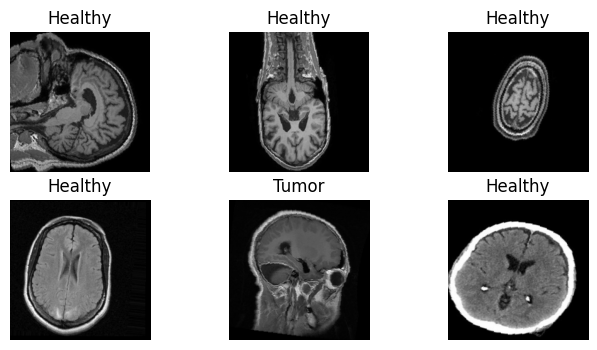

In [3]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

plt.figure(figsize=(8,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title("Tumor" if labels[i]==1 else "Healthy")
    plt.axis("off")
plt.show()


ResNet18 feature extractor (1-channel safe)

In [4]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet18FeatureExtractor(nn.Module):
    """
    ResNet18 backbone that outputs embeddings (B, 512).
    Modified to accept 1-channel MRI inputs.
    """
    def __init__(self, pretrained=True, train_backbone=True):
        super().__init__()

        # Load a ResNet18
        if pretrained:
            weights = models.ResNet18_Weights.DEFAULT
            backbone = models.resnet18(weights=weights)
        else:
            backbone = models.resnet18(weights=None)

        # ---- Modify first conv to accept 1 channel instead of 3 ----
        old_conv = backbone.conv1  # Conv2d(3, 64, ...)
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=(old_conv.bias is not None),
        )

        # If pretrained, initialize new_conv weights from old_conv by averaging RGB weights
        if pretrained:
            with torch.no_grad():
                new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)

        backbone.conv1 = new_conv

        # ---- Remove classifier head: keep everything up to avgpool ----
        self.backbone = backbone
        self.backbone.fc = nn.Identity()  # now forward returns (B, 512)

        # Freeze backbone if  want (optional)
        if not train_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, x):
        # x: (B, 1, 224, 224)
        emb = self.backbone(x)  # (B, 512)
        return emb


Quick sanity test

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

cnn_feat = ResNet18FeatureExtractor(pretrained=True, train_backbone=True).to(device)
cnn_feat.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    emb = cnn_feat(images)

print("Input shape:", images.shape)   # (B, 1, 224, 224)
print("Embedding shape:", emb.shape)  # (B, 512)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s] 


Input shape: torch.Size([16, 1, 224, 224])
Embedding shape: torch.Size([16, 512])


From ResNet18 feature extractor, we already have: 
embeddings.shape = (B, 512)
These values:

are continuous (floats)

represent feature strength

are NOT spikes yet

Preprocessing embeddings for spike encoding

Before rate coding, we must ensure values are in [0, 1], because they will be used as firing probabilities.

In [6]:
import torch

def normalize_embeddings(emb):
    """
    Normalize embeddings to [0, 1] per batch.
    emb: (B, F)
    """
    emb_min = emb.min(dim=1, keepdim=True)[0]
    emb_max = emb.max(dim=1, keepdim=True)[0]
    return (emb - emb_min) / (emb_max - emb_min + 1e-6)


Rate-based spike encoding (core of Step 3)
Idea recap

Each feature value → firing probability

At each time step, generate a spike (0 or 1)

Repeat for T time steps

Implementation: Rate Coding Encoder

In [7]:
def rate_code(embeddings, T=10):
    """
    Rate-based spike encoding.

    embeddings: (B, F) tensor in [0,1]
    T: number of time steps

    returns:
        spikes: (T, B, F) binary tensor
    """
    B, F = embeddings.shape

    # Expand embeddings to (T, B, F)
    emb_expanded = embeddings.unsqueeze(0).repeat(T, 1, 1)

    # Random numbers in [0,1]
    rand_uniform = torch.rand(T, B, F, device=embeddings.device)

    # Spike generation
    spikes = (rand_uniform < emb_expanded).float()

    return spikes


**Full Step 3 pipeline (CNN → spikes)**

In [8]:
# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"

cnn_feat.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    emb = cnn_feat(images)              # (B, 512)
    emb_norm = normalize_embeddings(emb)
    spikes = rate_code(emb_norm, T=10)  # (T, B, 512)

print("Embeddings:", emb.shape)
print("Spike tensor:", spikes.shape)


Embeddings: torch.Size([16, 512])
Spike tensor: torch.Size([10, 16, 512])


**Surrogate spike function (for backprop)**

In [9]:
import torch
import torch.nn as nn

class SurrogateHeaviside(torch.autograd.Function):
    """
    Forward: hard threshold
    Backward: smooth surrogate gradient (fast sigmoid derivative)
    """
    @staticmethod
    def forward(ctx, x, alpha=5.0):
        ctx.save_for_backward(x)
        ctx.alpha = alpha
        return (x > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        (x,) = ctx.saved_tensors
        alpha = ctx.alpha
        # fast sigmoid derivative: alpha * sigmoid(ax)*(1-sigmoid(ax))
        s = torch.sigmoid(alpha * x)
        grad = grad_output * alpha * s * (1 - s)
        return grad, None

def spike_fn(x, alpha=5.0):
    return SurrogateHeaviside.apply(x, alpha)


**CRIMF cell (regional current + membrane + multiple firing)**

This is a channelwise CRIMF-style cell:

Q(t) = regional current (longer memory)

U(t) = membrane potential

S(t) = output spikes (binary)

soft reset to allow multiple firing across time steps****

In [10]:
class CRIMFCell(nn.Module):
    """
    CRIMF-style spiking cell:
    - regional current Q(t) with decay
    - membrane U(t) with decay
    - binary spike output S(t)
    - channelwise learnable decays (taus) for hidden dimension
    """
    def __init__(self, hidden_dim, threshold=1.0, alpha=5.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.threshold = threshold
        self.alpha = alpha

        # Channelwise learnable decays (kept in (0,1) using sigmoid)
        self.logit_tau_q = nn.Parameter(torch.zeros(hidden_dim))  # for Q decay
        self.logit_tau_u = nn.Parameter(torch.zeros(hidden_dim))  # for U decay

    def init_state(self, batch_size, device):
        Q = torch.zeros(batch_size, self.hidden_dim, device=device)
        U = torch.zeros(batch_size, self.hidden_dim, device=device)
        return Q, U

    def forward(self, I_t, state):
        """
        I_t: (B, hidden_dim) input current at time t (from weighted spikes)
        state: (Q, U)
        returns: S_t (B, hidden_dim), new_state
        """
        Q, U = state

        # Convert logits -> (0,1) decays
        tau_q = torch.sigmoid(self.logit_tau_q).unsqueeze(0)  # (1, H)
        tau_u = torch.sigmoid(self.logit_tau_u).unsqueeze(0)  # (1, H)

        # Regional current integration
        Q = tau_q * Q + (1 - tau_q) * I_t

        # Membrane integration
        U = tau_u * U + (1 - tau_u) * Q

        # Spike generation (binary)
        S = spike_fn(U - self.threshold, alpha=self.alpha)

        # Soft reset (allows multiple firing over time)
        U = U - S * self.threshold

        return S, (Q, U)


**CRIMF layer (weights + CRIMF cell)**
This converts input spikes → hidden current → CRIMF neuron updates.

In [11]:
class CRIMFLayer(nn.Module):
    def __init__(self, in_dim, hidden_dim, threshold=1.0, alpha=5.0):
        super().__init__()
        self.fc = nn.Linear(in_dim, hidden_dim, bias=False)
        self.cell = CRIMFCell(hidden_dim, threshold=threshold, alpha=alpha)

    def forward(self, x_spikes):
        """
        x_spikes: (T, B, in_dim)
        returns:
          h_spikes: (T, B, hidden_dim)
        """
        T, B, _ = x_spikes.shape
        device = x_spikes.device
        state = self.cell.init_state(B, device)

        outs = []
        for t in range(T):
            I_t = self.fc(x_spikes[t])        # (B, hidden_dim)
            S_t, state = self.cell(I_t, state)
            outs.append(S_t)

        return torch.stack(outs, dim=0)  # (T, B, hidden_dim)


**CRIMF-SNN classifier (end-to-end)**

This produces class logits by counting (or averaging) spikes at the output.

In [12]:
class CRIMFSNNClassifier(nn.Module):
    def __init__(self, in_dim=512, hidden_dim=256, num_classes=2, T=10, threshold=1.0, alpha=5.0):
        super().__init__()
        self.T = T
        self.hidden = CRIMFLayer(in_dim, hidden_dim, threshold=threshold, alpha=alpha)
        self.readout = nn.Linear(hidden_dim, num_classes, bias=True)

    def forward(self, x_spikes):
        """
        x_spikes: (T, B, in_dim)
        returns logits: (B, num_classes)
        """
        h_spikes = self.hidden(x_spikes)     # (T, B, hidden_dim)

        # Aggregate across time (rate / spike count)
        h_rate = h_spikes.mean(dim=0)        # (B, hidden_dim)

        logits = self.readout(h_rate)        # (B, 2)
        return logits


**Quick sanity check (Step 4 forward pass)**

Run this to ensure your Step 3 spikes can be classified (forward only):

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# already have: spikes from Step 3 with shape (T,B,512)
# spikes = rate_code(...)

model_snn = CRIMFSNNClassifier(in_dim=512, hidden_dim=256, num_classes=2, T=10).to(device)
model_snn.eval()

with torch.no_grad():
    logits = model_snn(spikes.to(device))

print("Spikes shape:", spikes.shape)        # (T,B,512)
print("Logits shape:", logits.shape)        # (B,2)


Spikes shape: torch.Size([10, 16, 512])
Logits shape: torch.Size([16, 2])


**actual training loop**

In [24]:
import torch
import torch.nn as nn

# ----------------------------
# Helpers
# ----------------------------
def normalize_embeddings(emb: torch.Tensor) -> torch.Tensor:
    """
    Normalize embeddings to [0,1] per sample (per row).
    emb: (B, F)
    """
    emb_min = emb.min(dim=1, keepdim=True)[0]
    emb_max = emb.max(dim=1, keepdim=True)[0]
    return (emb - emb_min) / (emb_max - emb_min + 1e-6)

def rate_code(embeddings_01: torch.Tensor, T: int = 10) -> torch.Tensor:
    """
    Rate-based spike encoding.
    embeddings_01: (B, F) in [0,1]
    returns spikes: (T, B, F) in {0,1}
    """
    B, F = embeddings_01.shape
    emb_expanded = embeddings_01.unsqueeze(0).repeat(T, 1, 1)     # (T,B,F)
    rand_u = torch.rand(T, B, F, device=embeddings_01.device)     # (T,B,F)
    spikes = (rand_u < emb_expanded).float()
    return spikes

@torch.no_grad()
def compute_metrics_from_logits(logits: torch.Tensor, labels: torch.Tensor):
    """
    logits: (B,2), labels: (B,)
    returns correct_count, total_count
    """
    preds = logits.argmax(dim=1)
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct, total

# Simple confusion matrix for binary classification
@torch.no_grad()
def update_confusion(cm: torch.Tensor, logits: torch.Tensor, labels: torch.Tensor):
    """
    cm: (2,2) where rows=true, cols=pred
    """
    preds = logits.argmax(dim=1)
    for t, p in zip(labels.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1

def accuracy_from_cm(cm: torch.Tensor) -> float:
    return (cm.trace() / cm.sum().clamp_min(1)).item()

def precision_recall_f1_from_cm(cm: torch.Tensor):
    # cm rows=true [0,1], cols=pred [0,1]
    tn, fp = cm[0,0].item(), cm[0,1].item()
    fn, tp = cm[1,0].item(), cm[1,1].item()
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)
    return precision, recall, f1

# ----------------------------
# Step 5: Training + Testing
# ----------------------------
def train_one_epoch(
    cnn_feat: nn.Module,
    snn_model: nn.Module,
    train_loader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: str,
    T: int = 10,
    train_cnn: bool = False,
):
    """
    One training epoch for CNN -> spikes -> CRIMF-SNN classifier.
    """
    snn_model.train()
    if train_cnn:
        cnn_feat.train()
    else:
        cnn_feat.eval()  # freeze behavior like dropout/bn (ResNet has bn)

    running_loss = 0.0
    correct_total = 0
    n_total = 0

    for images, labels in train_loader:
        images = images.to(device)               # (B,1,224,224)
        labels = labels.to(device).long()        # (B,)

        optimizer.zero_grad(set_to_none=True)

        # CNN embeddings
        if train_cnn:
            emb = cnn_feat(images)               # (B,512)
        else:
            with torch.no_grad():
                emb = cnn_feat(images)

        # Normalize + spike encode
        emb01 = normalize_embeddings(emb)        # (B,512) in [0,1]
        spikes = rate_code(emb01, T=T)           # (T,B,512)

        # SNN forward -> logits
        logits = snn_model(spikes)               # (B,2)

        # Loss + backward
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item() * labels.size(0)
        c, t = compute_metrics_from_logits(logits.detach(), labels)
        correct_total += c
        n_total += t

    avg_loss = running_loss / max(1, n_total)
    acc = correct_total / max(1, n_total)
    return avg_loss, acc


@torch.no_grad()
def evaluate(
    cnn_feat: nn.Module,
    snn_model: nn.Module,
    data_loader,
    device: str,
    T: int = 10,
):
    """
    Evaluation (no learning) on val/test set.
    """
    cnn_feat.eval()
    snn_model.eval()

    cm = torch.zeros(2, 2, device=device)  # confusion matrix

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device).long()

        emb = cnn_feat(images)                  # (B,512)
        emb01 = normalize_embeddings(emb)
        spikes = rate_code(emb01, T=T)          # (T,B,512)
        logits = snn_model(spikes)              # (B,2)

        update_confusion(cm, logits, labels)

    acc = accuracy_from_cm(cm)
    precision, recall, f1 = precision_recall_f1_from_cm(cm)
    return acc, precision, recall, f1, cm.detach().cpu()


# ----------------------------
# MAIN TRAINING RUN
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# We already have these from previous steps:
# cnn_feat = ResNet18FeatureExtractor(...).to(device)
# model_snn = CRIMFSNNClassifier(in_dim=512, hidden_dim=256, num_classes=2, T=10).to(device)
# train_loader, test_loader = ...

T = 10
train_cnn = False  # set True if you want to fine-tune ResNet too

# If we freeze CNN, optimize only SNN parameters (recommended first)
params = list(model_snn.parameters()) + (list(cnn_feat.parameters()) if train_cnn else [])
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

num_epochs = 10

train_acc_history = []
test_acc_history = []
test_recall_history = []



for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(
        cnn_feat=cnn_feat,
        snn_model=model_snn,
        train_loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        T=T,
        train_cnn=train_cnn,
    )

    test_acc, prec, rec, f1, cm = evaluate(
        cnn_feat=cnn_feat,
        snn_model=model_snn,
        data_loader=test_loader,
        device=device,
        T=T,
    )

    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    test_recall_history.append(rec)


    print(f"Epoch {epoch:02d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Acc: {test_acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)


Epoch 01/10 | Train Loss: 0.0865 | Train Acc: 0.9697 | Test Acc: 0.9746 | Prec: 0.9959 | Rec: 0.9646 | F1: 0.9800
Confusion Matrix (rows=true, cols=pred):
tensor([[139.,   1.],
        [  9., 245.]])
Epoch 02/10 | Train Loss: 0.0670 | Train Acc: 0.9747 | Test Acc: 0.9721 | Prec: 0.9728 | Rec: 0.9843 | F1: 0.9785
Confusion Matrix (rows=true, cols=pred):
tensor([[133.,   7.],
        [  4., 250.]])
Epoch 03/10 | Train Loss: 0.0872 | Train Acc: 0.9679 | Test Acc: 0.9772 | Prec: 0.9842 | Rec: 0.9803 | F1: 0.9822
Confusion Matrix (rows=true, cols=pred):
tensor([[136.,   4.],
        [  5., 249.]])
Epoch 04/10 | Train Loss: 0.0739 | Train Acc: 0.9743 | Test Acc: 0.9695 | Prec: 0.9919 | Rec: 0.9606 | F1: 0.9760
Confusion Matrix (rows=true, cols=pred):
tensor([[138.,   2.],
        [ 10., 244.]])
Epoch 05/10 | Train Loss: 0.0960 | Train Acc: 0.9625 | Test Acc: 0.9645 | Prec: 0.9918 | Rec: 0.9528 | F1: 0.9719
Confusion Matrix (rows=true, cols=pred):
tensor([[138.,   2.],
        [ 12., 242.]])


In [25]:
print("Test dataset size:", len(test_loader.dataset))
print("Train dataset size:", len(train_loader.dataset))

Test dataset size: 394
Train dataset size: 2214


**train vs test accuracy**

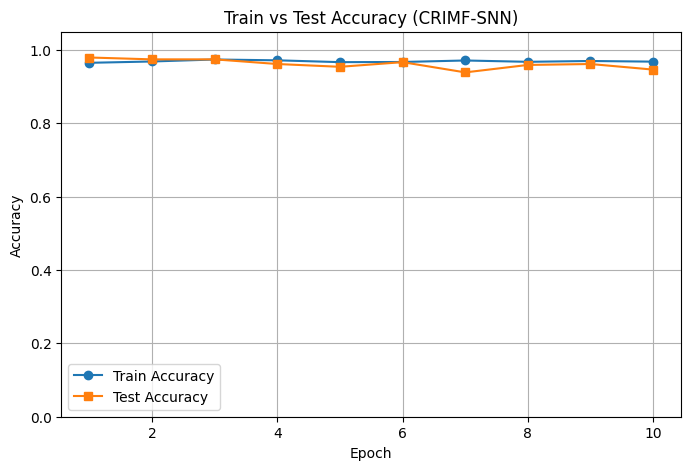

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc_history, marker='o', label="Train Accuracy")
plt.plot(epochs, test_acc_history, marker='s', label="Test Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (CRIMF-SNN)")
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)

plt.show()


Recall Vs Epoch

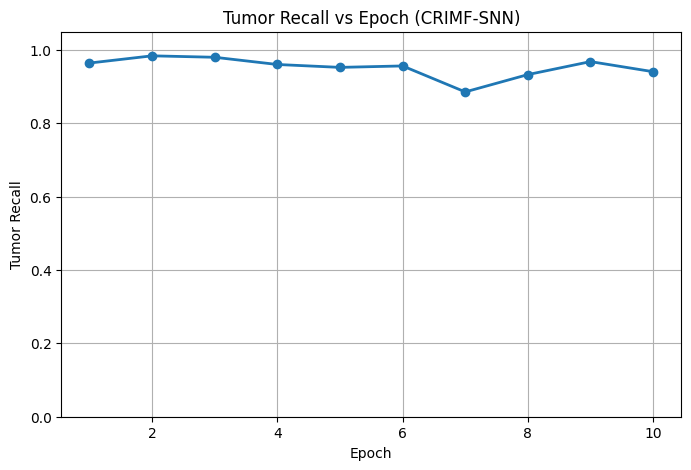

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, len(test_recall_history) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, test_recall_history, marker='o', linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Tumor Recall")
plt.title("Tumor Recall vs Epoch (CRIMF-SNN)")

plt.ylim(0, 1.05)
plt.grid(True)

plt.show()


**Visualize sample predictions (code)**
Helper to get class names

In [16]:
idx_to_class = {v: k for k, v in test_loader.dataset.class_to_idx.items()}
print(idx_to_class)


{0: 'healthy', 1: 'tumor'}


In [17]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_predictions(
    cnn_feat,
    snn_model,
    data_loader,
    device,
    T=10,
    num_samples=6
):
    cnn_feat.eval()
    snn_model.eval()

    images, labels = next(iter(data_loader))
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():
        emb = cnn_feat(images)
        emb_min = emb.min(dim=1, keepdim=True)[0]
        emb_max = emb.max(dim=1, keepdim=True)[0]
        emb01 = (emb - emb_min) / (emb_max - emb_min + 1e-6)

        spikes = rate_code(emb01, T=T)
        logits = snn_model(spikes)
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

    # Plot
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        img = images[i].cpu().squeeze(0)  # (H,W)
        true_label = idx_to_class[labels[i].item()]
        pred_label = idx_to_class[preds[i].item()]
        confidence = probs[i, preds[i]].item()

        plt.subplot(2, num_samples//2, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(
            f"GT: {true_label}\n"
            f"Pred: {pred_label}\n"
            f"Conf: {confidence:.2f}",
            color="green" if true_label == pred_label else "red"
        )

    plt.tight_layout()
    plt.show()


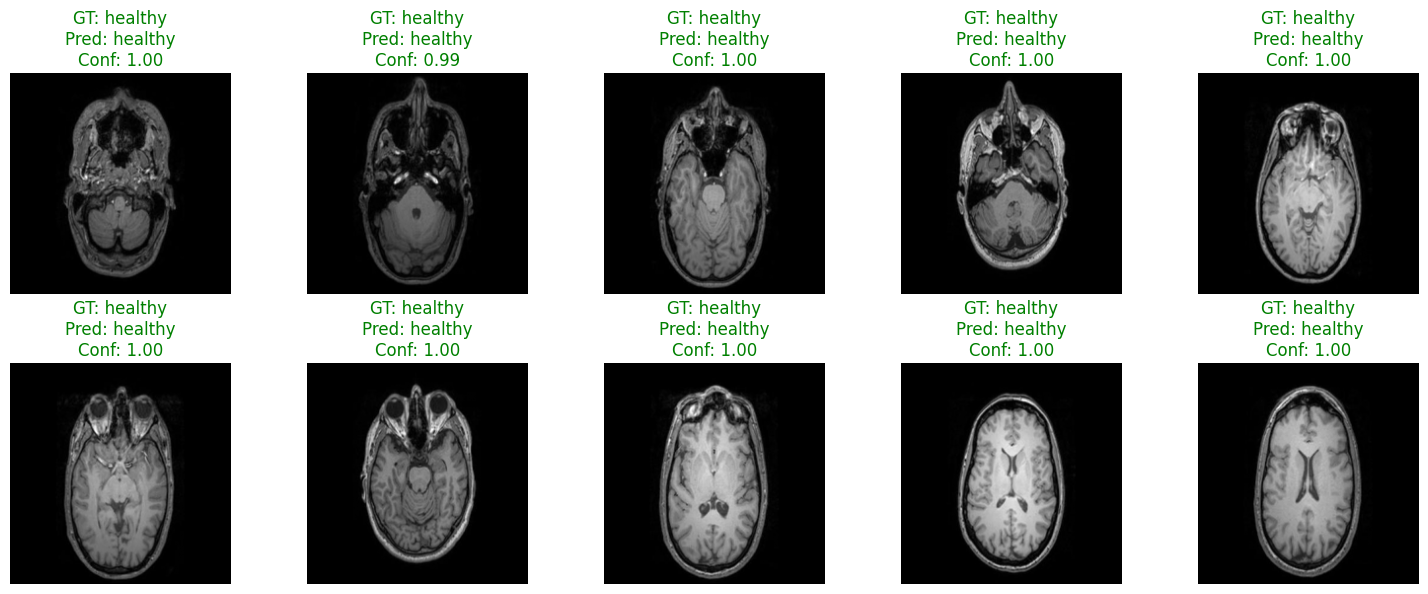

In [18]:
visualize_predictions(
    cnn_feat=cnn_feat,
    snn_model=model_snn,
    data_loader=test_loader,
    device=device,
    T=10,
    num_samples=10
)


In [19]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

#Helper to get class names
idx_to_class = {v: k for k, v in test_loader.dataset.class_to_idx.items()}

@torch.no_grad()
def visualize_balanced_predictions(
    cnn_feat,
    snn_model,
    dataset,          # pass test_loader.dataset (NOT the loader)
    device,
    T=10,
    per_class=4       # show 4 healthy + 4 tumor
):
    cnn_feat.eval()
    snn_model.eval()

    # Collect indices per class
    class_to_indices = {0: [], 1: []}
    for i in range(len(dataset)):
        _, y = dataset[i]
        if y in class_to_indices and len(class_to_indices[y]) < per_class:
            class_to_indices[y].append(i)
        if len(class_to_indices[0]) >= per_class and len(class_to_indices[1]) >= per_class:
            break

    # Safety check
    if len(class_to_indices[0]) < per_class or len(class_to_indices[1]) < per_class:
        print("Not enough samples for one of the classes in this dataset.")
        print({k: len(v) for k, v in class_to_indices.items()})
        return

    # Build a small batch with both classes
    chosen = class_to_indices[0] + class_to_indices[1]
    imgs = []
    labels = []
    for idx in chosen:
        x, y = dataset[idx]
        imgs.append(x)
        labels.append(y)

    images = torch.stack(imgs, dim=0).to(device)           # (N,1,H,W)
    labels = torch.tensor(labels, device=device).long()    # (N,)

    # Forward: CNN -> spikes -> SNN
    emb = cnn_feat(images)                                 # (N,512)
    emb01 = (emb - emb.min(dim=1, keepdim=True)[0]) / (emb.max(dim=1, keepdim=True)[0] - emb.min(dim=1, keepdim=True)[0] + 1e-6)

    spikes = rate_code(emb01, T=T)                          # (T,N,512)
    logits = snn_model(spikes)                              # (N,2)
    probs = F.softmax(logits, dim=1)
    preds = probs.argmax(dim=1)

    # Plot
    N = images.size(0)
    cols = min(4, N)
    rows = (N + cols - 1) // cols
    plt.figure(figsize=(4*cols, 4*rows))

    for i in range(N):
        img = images[i].detach().cpu().squeeze(0)          # (H,W)
        gt = idx_to_class[labels[i].item()]
        pr = idx_to_class[preds[i].item()]
        conf = probs[i, preds[i]].item()

        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"GT: {gt}\nPred: {pr}\nConf: {conf:.2f}",
                  color="green" if gt == pr else "red")

    plt.tight_layout()
    plt.show()


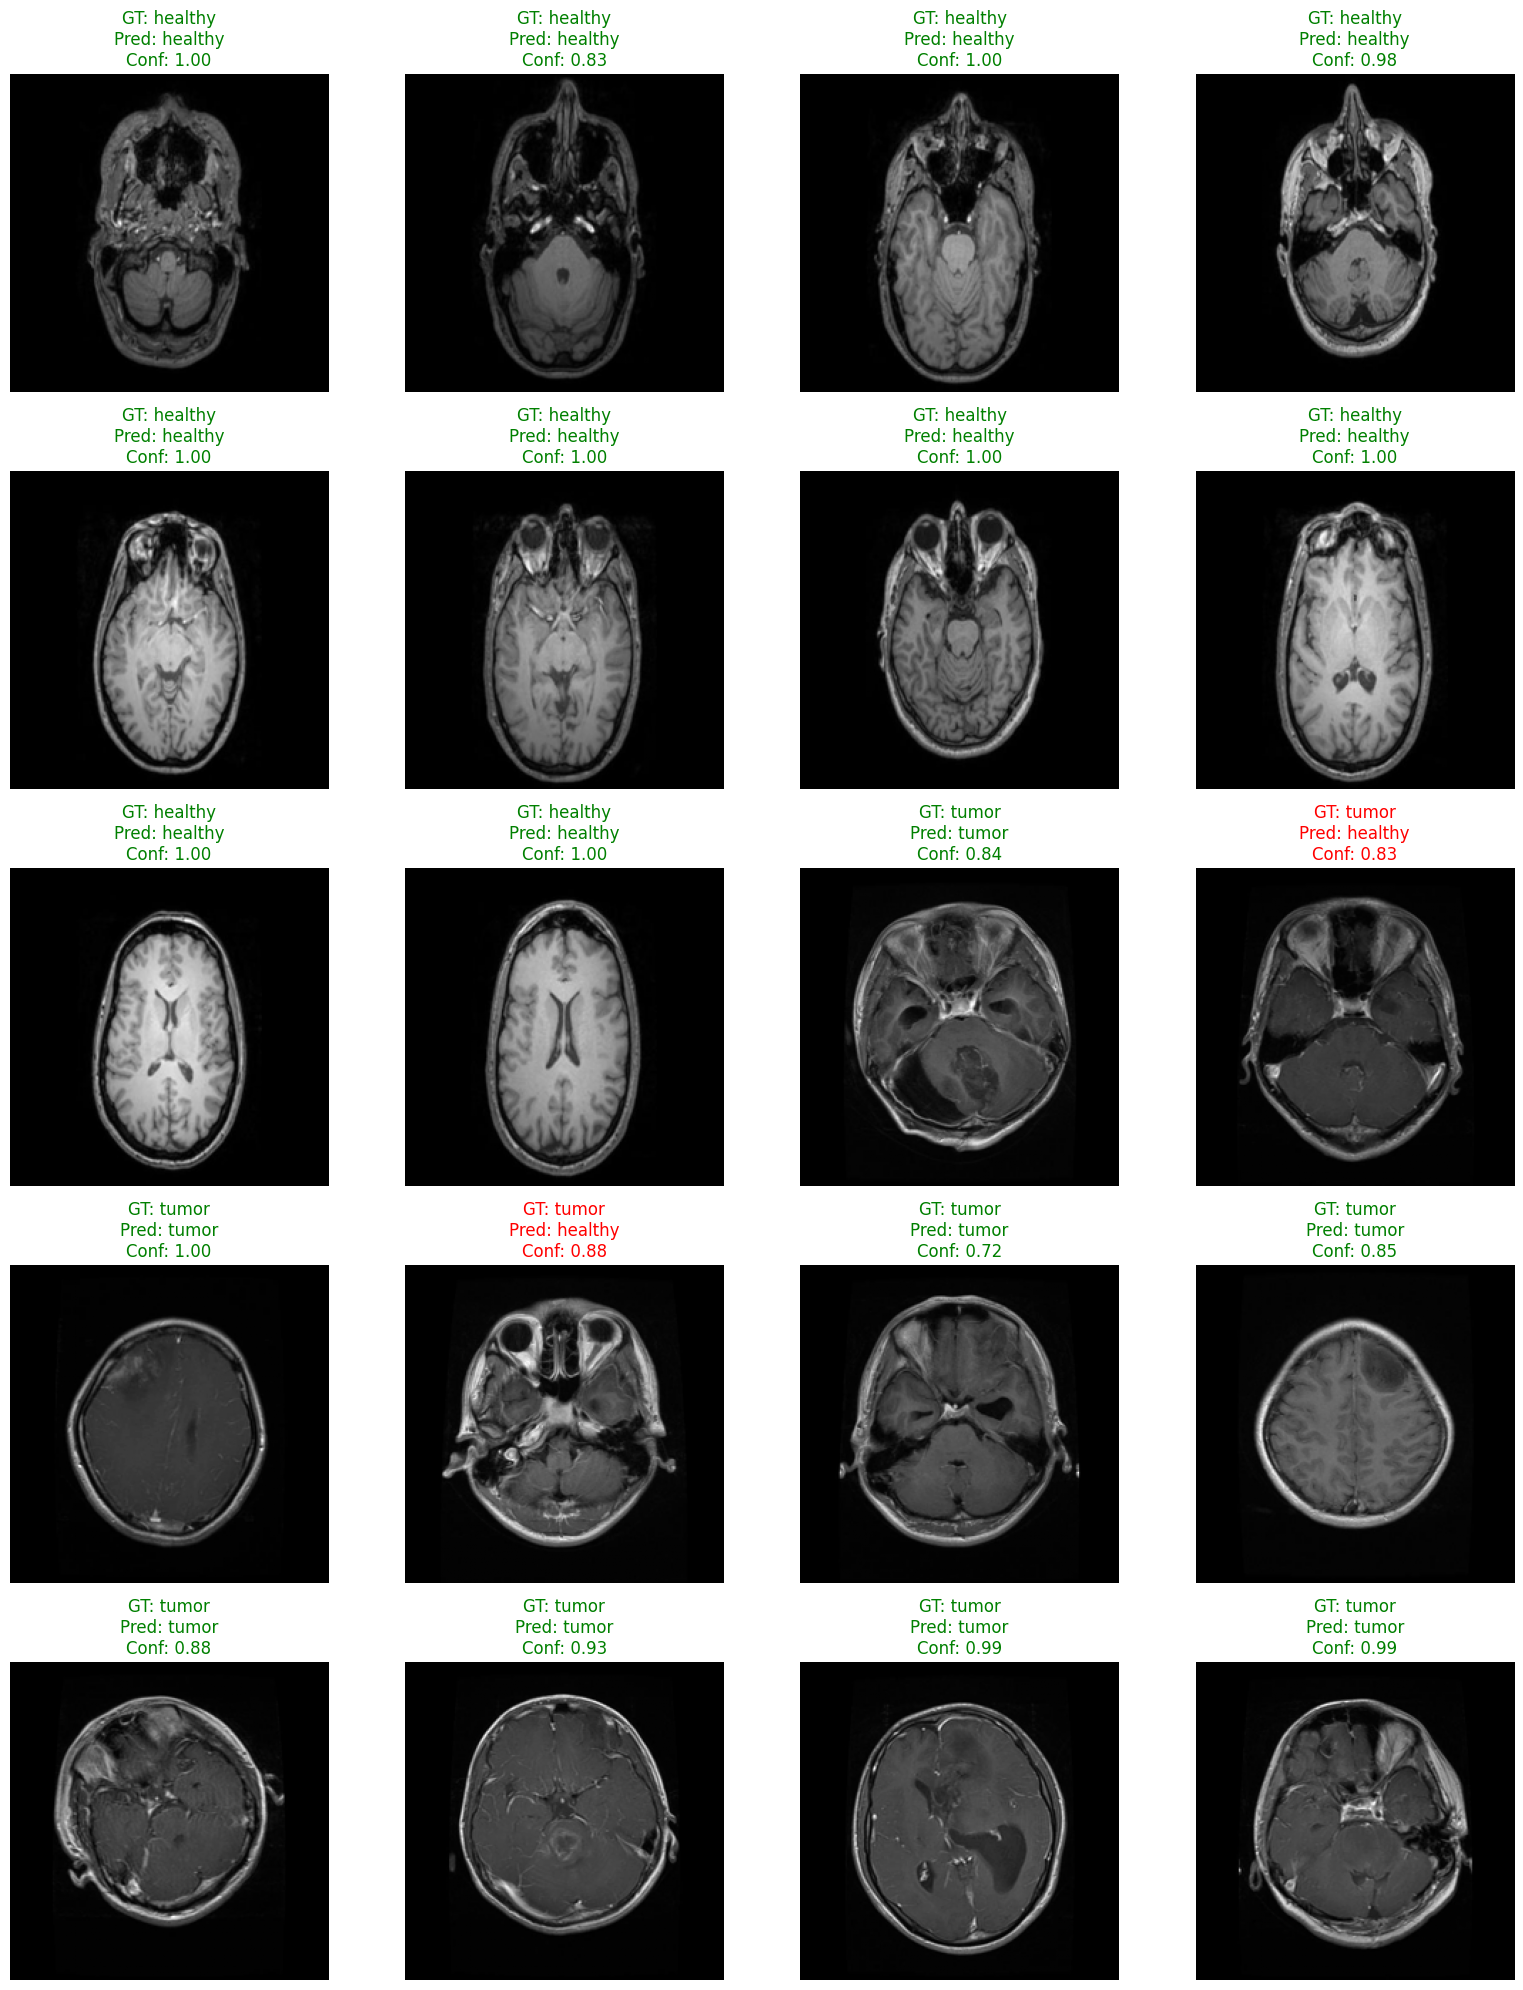

In [20]:
visualize_balanced_predictions(
    cnn_feat=cnn_feat,
    snn_model=model_snn,
    dataset=test_loader.dataset,
    device=device,
    T=10,
    per_class=10
)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(
    final_cm.numpy(),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Healthy", "Tumor"],
    yticklabels=["Healthy", "Tumor"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Final Confusion Matrix (CRIMF-SNN)")
plt.tight_layout()
plt.show()
